In [33]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import dask.array as dsar
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

# Parallelized Bartlett's Method
For long data sets that have reached statistical equilibrium, it is useful to chunk the data, calculate the periodogram for each chunk and then take the average to reduce variance.

In [39]:
n = int(2**8)
da = xr.DataArray(np.random.rand(n,int(n/2),int(n/2)), dims=['time','y','x'])
da

<xarray.DataArray (time: 256, y: 128, x: 128)>
array([[[ 0.708204,  0.623306, ...,  0.633413,  0.175358],
        [ 0.081545,  0.830202, ...,  0.868449,  0.127926],
        ..., 
        [ 0.191606,  0.293656, ...,  0.556694,  0.082077],
        [ 0.792495,  0.680035, ...,  0.586443,  0.723934]],

       [[ 0.473775,  0.753015, ...,  0.81156 ,  0.784373],
        [ 0.534178,  0.587411, ...,  0.455145,  0.35406 ],
        ..., 
        [ 0.731346,  0.186341, ...,  0.740023,  0.082606],
        [ 0.937825,  0.254841, ...,  0.100474,  0.221195]],

       ..., 
       [[ 0.472905,  0.655343, ...,  0.580102,  0.733418],
        [ 0.051623,  0.434491, ...,  0.788993,  0.63998 ],
        ..., 
        [ 0.490789,  0.074917, ...,  0.946635,  0.350554],
        [ 0.789233,  0.90381 , ...,  0.074425,  0.324881]],

       [[ 0.166927,  0.891967, ...,  0.378693,  0.107187],
        [ 0.336705,  0.545057, ...,  0.867882,  0.185894],
        ..., 
        [ 0.947818,  0.855856, ...,  0.095839,  0.06

## One dimension
### Discrete Fourier Transform

In [40]:
daft = xrft.dft(da.chunk({'time':int(n/4)}), dim=['time'], shift=False , chunks_to_segments=True).compute()
daft

<xarray.DataArray 'fftn-ebc9f8f719f72665cabdd992420a392b' (time_segment: 4, freq_time: 64, y: 128, x: 128)>
array([[[[ 34.678448+0.j      , ...,  33.360196+0.j      ],
         ..., 
         [ 30.047755+0.j      , ...,  32.477188+0.j      ]],

        ..., 
        [[ -0.839324-2.093284j, ...,   0.783955+1.058623j],
         ..., 
         [  0.968250+1.362974j, ...,   0.350211+1.043625j]]],


       ..., 
       [[[ 33.932557+0.j      , ...,  26.678665+0.j      ],
         ..., 
         [ 33.875314+0.j      , ...,  26.582230+0.j      ]],

        ..., 
        [[ -2.666363-1.368176j, ...,   1.331759-3.620162j],
         ..., 
         [  1.562490+1.308685j, ...,   2.192812-0.751168j]]]])
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3
  * freq_time          (freq_time) float64 0.0 0.01562 0.03125 0.04688 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ..

In [41]:
data = da.chunk({'time':int(n/4)}).data
data_rs = data.reshape((4,int(n/4),int(n/2),int(n/2)))
da_rs = xr.DataArray(data_rs, dims=['time_segment','time','y','x'])
da1 = xr.DataArray(dsar.fft.fftn(data_rs, axes=[1]).compute(),
                   dims=['time_segment','freq_time','y','x'])
da1

<xarray.DataArray (time_segment: 4, freq_time: 64, y: 128, x: 128)>
array([[[[ 34.678448+0.j      , ...,  33.360196+0.j      ],
         ..., 
         [ 30.047755+0.j      , ...,  32.477188+0.j      ]],

        ..., 
        [[ -0.839324-2.093284j, ...,   0.783955+1.058623j],
         ..., 
         [  0.968250+1.362974j, ...,   0.350211+1.043625j]]],


       ..., 
       [[[ 33.932557+0.j      , ...,  26.678665+0.j      ],
         ..., 
         [ 33.875314+0.j      , ...,  26.582230+0.j      ]],

        ..., 
        [[ -2.666363-1.368176j, ...,   1.331759-3.620162j],
         ..., 
         [  1.562490+1.308685j, ...,   2.192812-0.751168j]]]])
Dimensions without coordinates: time_segment, freq_time, y, x

We assert that our calculations give equal results.

In [42]:
npt.assert_almost_equal(da1, daft.values)

### Power Spectrum

In [43]:
ps = xrft.power_spectrum(da.chunk({'time':int(n/4)}), dim=['time'], chunks_to_segments=True)
ps

<xarray.DataArray 'concatenate-1be9636e43154eccfc587490ca0062c4' (time_segment: 4, freq_time: 64, y: 128, x: 128)>
dask.array<truediv, shape=(4, 64, 128, 128), dtype=float64, chunksize=(1, 32, 128, 128)>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3
  * freq_time          (freq_time) float64 -0.5 -0.4844 -0.4688 -0.4531 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    freq_time_spacing  float64 0.01562

Taking the mean over the segments gives the Barlett's estimate.

In [44]:
ps = ps.mean(['time_segment','y','x'])
ps

<xarray.DataArray 'concatenate-1be9636e43154eccfc587490ca0062c4' (freq_time: 64)>
dask.array<mean_agg-aggregate, shape=(64,), dtype=float64, chunksize=(32,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.5 -0.4844 -0.4688 -0.4531 ...
    freq_time_spacing  float64 0.01562

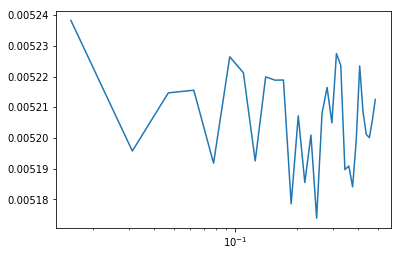

In [49]:
fig, ax = plt.subplots()
ax.semilogx(ps.freq_time[int(n/8)+1:], ps[int(n/8)+1:])

## Two dimension
### Discrete Fourier Transform

In [50]:
daft = xrft.dft(da.chunk({'y':32,'x':32}), dim=['y','x'], shift=False , chunks_to_segments=True).compute()
daft

<xarray.DataArray 'fftn-ac97487485e04b34c78d3bb19abd656f' (time: 256, y_segment: 4, freq_y: 32, x_segment: 4, freq_x: 32)>
array([[[[[  5.155037e+02 +0.j      , ...,  -9.064487e-02 +4.346549j],
          ..., 
          [  5.207532e+02 +0.j      , ...,   1.652457e+00 -1.577071j]],

         ..., 
         [[ -2.151390e+00 -3.923976j, ...,   5.437534e+00 -2.673446j],
          ..., 
          [ -9.625904e+00 -3.852991j, ...,   4.701084e+00 +8.104852j]]],


        ..., 
        [[[  5.125364e+02 +0.j      , ...,   9.436120e+00 +0.416432j],
          ..., 
          [  5.131432e+02 +0.j      , ...,  -7.539077e+00 -7.660807j]],

         ..., 
         [[  1.408086e+01 +5.188298j, ...,  -7.208214e+00 -0.392723j],
          ..., 
          [ -5.457056e-01 +0.931977j, ...,   8.330142e+00 +7.106618j]]]],



       ..., 
       [[[[  5.025914e+02 +0.j      , ...,  -3.253753e+00 +2.069255j],
          ..., 
          [  5.150235e+02 +0.j      , ...,   3.429467e-01 +0.507274j]],

         ..., 

In [51]:
data = da.chunk({'y':32,'x':32}).data
data_rs = data.reshape((256,4,32,4,32))
da_rs = xr.DataArray(data_rs, dims=['time','y_segment','y','x_segment','x'])
da2 = xr.DataArray(dsar.fft.fftn(data_rs, axes=[2,4]).compute(),
                   dims=['time','y_segment','freq_y','x_segment','freq_x'])
da2

<xarray.DataArray (time: 256, y_segment: 4, freq_y: 32, x_segment: 4, freq_x: 32)>
array([[[[[  5.155037e+02 +0.j      , ...,  -9.064487e-02 +4.346549j],
          ..., 
          [  5.207532e+02 +0.j      , ...,   1.652457e+00 -1.577071j]],

         ..., 
         [[ -2.151390e+00 -3.923976j, ...,   5.437534e+00 -2.673446j],
          ..., 
          [ -9.625904e+00 -3.852991j, ...,   4.701084e+00 +8.104852j]]],


        ..., 
        [[[  5.125364e+02 +0.j      , ...,   9.436120e+00 +0.416432j],
          ..., 
          [  5.131432e+02 +0.j      , ...,  -7.539077e+00 -7.660807j]],

         ..., 
         [[  1.408086e+01 +5.188298j, ...,  -7.208214e+00 -0.392723j],
          ..., 
          [ -5.457056e-01 +0.931977j, ...,   8.330142e+00 +7.106618j]]]],



       ..., 
       [[[[  5.025914e+02 +0.j      , ...,  -3.253753e+00 +2.069255j],
          ..., 
          [  5.150235e+02 +0.j      , ...,   3.429467e-01 +0.507274j]],

         ..., 
         [[ -8.339027e+00 +3.417548j, .

We assert that our calculations give equal results.

In [52]:
npt.assert_almost_equal(da2, daft.values)

### Power Spectrum

In [53]:
ps = xrft.power_spectrum(da.chunk({'y':64,'x':64}), dim=['y','x'], chunks_to_segments=True, detrend='constant')
ps = ps.mean(['time','y_segment','x_segment'])
ps

<xarray.DataArray 'concatenate-4377450b24443f054e4ccb5b2ff1fe77' (freq_y: 64, freq_x: 64)>
dask.array<mean_agg-aggregate, shape=(64, 64), dtype=float64, chunksize=(32, 32)>
Coordinates:
  * freq_y          (freq_y) float64 -0.5 -0.4844 -0.4688 -0.4531 -0.4375 ...
  * freq_x          (freq_x) float64 -0.5 -0.4844 -0.4688 -0.4531 -0.4375 ...
    freq_y_spacing  float64 0.01562
    freq_x_spacing  float64 0.01562

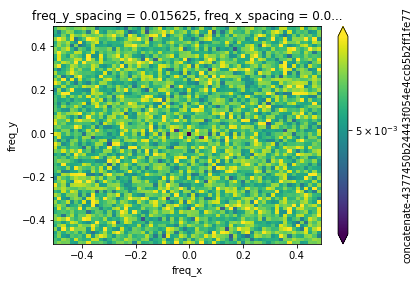

In [64]:
fig, ax = plt.subplots()
ps.plot(ax=ax, norm=colors.LogNorm(), vmin=4.5e-3, vmax=5.5e-3)